# MadMiner particle physics tutorial

# Part 3a: Training a likelihood ratio estimator

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3a of this tutorial we will finally train a neural network to estimate likelihood ratios. We assume that you have run part 1 and 2a of this tutorial. If, instead of 2a, you have run part 2b, you just have to load a different filename later.

## Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import ParameterizedRatioEstimator


/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [3]:
sampler = SampleAugmenter('data/delphes_data_shuffled.h5')

18:49 madminer.analysis    INFO    Loading data from data/delphes_data_shuffled.h5
18:49 madminer.analysis    INFO    Found 1 parameters
18:49 madminer.analysis    INFO    Did not find nuisance parameters
18:49 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
18:49 madminer.analysis    INFO    Found 35 observables
18:49 madminer.analysis    INFO    Found 3635115 events
18:49 madminer.analysis    INFO      856510 signal events sampled from benchmark no-higgs
18:49 madminer.analysis    INFO      821845 signal events sampled from benchmark 0.8_k
18:49 madminer.analysis    INFO      922750 signal events sampled from benchmark sm
18:49 madminer.analysis    INFO      112840 signal events sampled from benchmark 1.2_k
18:49 madminer.analysis    INFO      807988 signal events sampled from benchmark 1.5_k
18:49 madminer.analysis    INFO      113182 signal events sampled from benchmark 1.35_k
18:49 madminer.analysis    INFO    Found morphing setup with 5 components
18:49 madmi

The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `sample_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `sample_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `sample_train_density()` for neural density estimation techniques like MAF or SCANDAL;
- `sample_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `sample_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `sample_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `benchmark()`, `benchmarks()`, `morphing_point()`, `morphing_points()`, and `random_morphing_points()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the ALICES method, so we focus on the `extract_samples_train_ratio()` function. We'll sample the numerator hypothesis in the likelihood ratio with 1000 points drawn from a Gaussian prior, and fix the denominator hypothesis to the SM.

Note the keyword `sample_only_from_closest_benchmark=True`, which makes sure that for each parameter point we only use the events that were originally (in MG) generated from the closest benchmark. This reduces the statistical fluctuations in the outcome quite a bit.

## 4. Evaluate likelihood ratio estimator

`estimator.evaluate_log_likelihood_ratio(theta,x)` estimated the log likelihood ratio and the score for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood ratio and 25\*100 estimates for the score, both indexed by `[i_theta,i_x]`.

In [23]:
theta_grid = np.linspace(0.,2.,11).reshape((-1,1))
theta1_grid = np.ones_like(theta_grid)
mu_grid = np.sign(theta_grid) * theta_grid ** 4

In [24]:
theta1_grid.shape, theta_grid.shape

((11, 1), (11, 1))

In [25]:
estimator = ParameterizedRatioEstimator(
    n_hidden=(300,),
    activation="tanh"
)
estimator.load('models/alices')

log_r_hat, _ = estimator.evaluate_log_likelihood_ratio(
    #theta='data/samples/theta_grid.npy',
    theta=theta_grid,
    x='data/samples/x_test.npy',
    evaluate_score=False
)

19:00 madminer.ml          INFO    Loading model from models/alices
19:00 madminer.ml          INFO    Loading evaluation data
19:00 madminer.utils.vario INFO      Loading data/samples/x_test.npy into RAM
19:00 madminer.ml          INFO    Starting ratio evaluation for 4400000 x-theta combinations
19:02 madminer.ml          INFO    Evaluation done


In [28]:
nllr = -2* np.mean(log_r_hat, axis=1)

Let's look at the result:

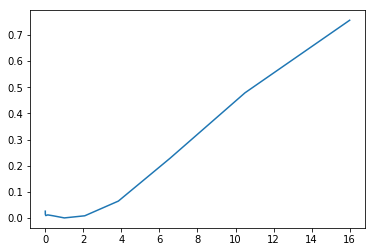

In [29]:
plt.plot(mu_grid, nllr - min(nllr))

In [11]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(theta_each[0] - bin_size/2, theta_each[-1] + bin_size/2, len(theta_each)+1)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

expected_llr = np.mean(log_r_hat,axis=1)
#best_fit = theta_grid[np.argmin(-2.*expected_llr)]
best_fit = theta_grid[np.argmin(-2.*expected_llr)]

# plt.scatter(theta_grid**2, -2. * expected_llr)
# plt.scatter(best_fit**2, (-2. * expected_llr).min(), s=80., color='black', marker='*', label="Best Fit")
plt.scatter(theta_grid, -2. * expected_llr)
plt.scatter(best_fit, (-2. * expected_llr).min(), s=80., color='black', marker='*', label="Best Fit")
print (best_fit)


#plt.xlabel(r'$\theta_0$')
#plt.xlabel(r'$\mu$')
plt.ylabel(r'-2* expected llr Alices')

plt.tight_layout()
plt.legend()
plt.show()


NameError: name 'theta_each' is not defined

Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood ratio function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!

In [ ]:
theta_grid


In [8]:
log_r_hat.shape, _.shape

((31, 400000), (31,))